In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf

In [3]:
def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Note this function is specifically designed to plot Tensorflow training output
    Args:
      hist_df : pandas DataFrame with four columns
                For 'x' values, we will use index
                first column is accuracy
                Second column is loss
                third column is val_accuracy
                fourth column is val_loss
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6)) # instantiate plot

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
 
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [4]:
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production


EPOCHS = 500 # number of cycles to run
ALPHA = 0.01 # learning rate
WEIGHT_DECAY = 0.001
BATCH_SIZE = 32
TRAIN_SIZE = BATCH_SIZE * 9

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [5]:
data_df = pd.read_csv('household_power_consumption.txt', sep=';', parse_dates={'dt': ['Date', 'Time']}, dayfirst=True, low_memory= False, na_values=['nan', '?'], index_col = 'dt')
data_df.shape

C:\Users\duasp\AppData\Local\Temp\ipykernel_5808\2528488343.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data_df = pd.read_csv('household_power_consumption.txt', sep=';', parse_dates={'dt': ['Date', 'Time']}, dayfirst=True, low_memory= False, na_values=['nan', '?'], index_col = 'dt')


(2075259, 7)

In [6]:
data_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
cols = data_df.columns

for col in cols:
    print(f'\n Columsn Name: {col}: {data_df[col].unique()}')


 Columsn Name: Global_active_power: [4.216 5.36  5.374 ... 9.63  9.648 8.6  ]

 Columsn Name: Global_reactive_power: [0.418 0.436 0.498 0.502 0.528 0.522 0.52  0.51  0.47  0.478 0.398 0.422
 0.282 0.152 0.156 0.    0.076 0.09  0.2   0.058 0.18  0.144 0.118 0.108
 0.202 0.192 0.186 0.116 0.136 0.148 0.16  0.158 0.1   0.082 0.05  0.052
 0.162 0.086 0.048 0.054 0.068 0.166 0.174 0.178 0.188 0.088 0.08  0.07
 0.084 0.074 0.106 0.092 0.064 0.046 0.138 0.134 0.132 0.12  0.13  0.154
 0.078 0.142 0.14  0.146 0.15  0.17  0.102 0.072 0.06  0.056 0.062 0.112
 0.066 0.172 0.168 0.194 0.184 0.096 0.164 0.182 0.094 0.098 0.176 0.19
 0.204 0.22  0.198 0.208 0.244 0.334 0.298 0.296 0.286 0.278 0.104 0.258
 0.238 0.256 0.214 0.23  0.21  0.24  0.124 0.122 0.27  0.302 0.272 0.25
 0.294 0.3   0.128 0.126 0.234 0.242 0.316 0.28  0.288 0.224 0.11  0.248
 0.254 0.222 0.246 0.216 0.212 0.114 0.206 0.228 0.226 0.196 0.218 0.368
 0.338 0.31  0.304 0.292 0.268 0.266 0.26  0.396 0.38  0.4   0.384 0.416
 0.404 0.

In [8]:
data_df = data_df.fillna(data_df.mean())


In [9]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [10]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2075259.0,1.091615,1.050655,0.076,0.310,0.630,1.520,11.122
Global_reactive_power,2075259.0,0.123714,0.112014,0.000,0.048,0.102,0.192,1.390
Voltage,2075259.0,240.839858,3.219643,223.200,239.020,240.960,242.860,254.150
Global_intensity,2075259.0,4.627759,4.416490,0.200,1.400,2.800,6.400,48.400
Sub_metering_1,2075259.0,1.121923,6.114397,0.000,0.000,0.000,0.000,88.000
Sub_metering_2,2075259.0,1.298520,5.785470,0.000,0.000,0.000,1.000,80.000
Sub_metering_3,2075259.0,6.458447,8.384178,0.000,0.000,1.000,17.000,31.000


In [11]:
df_sample = data_df.resample('h').mean()
df_sample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [12]:
scaler = MinMaxScaler()
df_sample['var1_t'] = df_sample['Global_active_power'].shift(-1)
df_sample=df_sample.rename({'Global_active_power':'var1',
                            'Global_reactive_power':'var2',
                            'Voltage':'var3',
                            'Global_intensity':'var4',	
                            'Sub_metering_1':'var5',
                            'Sub_metering_2':'var6',
                            'Sub_metering_3':'var7',
                           },axis=1)

df_sample=df_sample.dropna()
reframed = scaler.fit_transform(df_sample)
reframed[:, :5]
pd.DataFrame(reframed).head()

,0,1,2,3,4,5,6,7
0,0.636816,0.283776,0.337945,0.631157,0.0,0.011366,0.782418,0.545045
1,0.545045,0.088127,0.335501,0.541487,0.0,0.144652,0.782676,0.509006
2,0.509006,0.094957,0.283802,0.502152,0.0,0.030869,0.774169,0.488550
3,0.488550,0.081648,0.315987,0.481110,0.0,0.000000,0.778809,0.455597
4,0.455597,0.083705,0.434417,0.449904,0.0,0.008973,0.798917,0.322555


In [13]:
df_sample.tail()

,var1,var2,var3,var4,var5,var6,var7,var1_t
dt,,,,,,,,
2010-11-26 16:00:00,1.067933,0.215633,240.457833,4.610000,0.0,0.950000,0.000000,1.725900
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667,1.573467
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000,1.659333
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000,1.163700
2010-11-26 20:00:00,1.163700,0.061167,239.396000,4.913333,0.0,1.066667,0.000000,0.934667


In [14]:
split= 365*24

train=reframed[:split]
test= reframed[split:]
X_train=train[:,:-1]
y_train=train[:,-1]
X_test=test[:,:-1]
y_test=test[:,-1]
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((8760, 7), (8760,), (25828, 7), (25828,))

Shape (samples,timesteps,features)

In [16]:
X_train=X_train.reshape((X_train.shape[0],1,X_train.shape[1]))
X_test=X_test.reshape((X_test.shape[0],1,X_test.shape[1]))

X_train.shape,X_test.shape

((8760, 1, 7), (25828, 1, 7))

Prepare Model :sequential

In [18]:

input_shape = (X_train.shape[1],X_train.shape[2]) #2 features
n_units = 512
dor1=0.2
dor2=0.5
model = tf.keras.Sequential()

model.add(tf.keras.Input(input_shape))

model.add(tf.keras.layers.LSTM(units = n_units, activation='tanh'))  #check documentation
model.add(tf.keras.layers.Dropout(dor1)) 
model.add(tf.keras.layers.Dense(units = 128, activation='relu')) 
model.add(tf.keras.layers.Dropout(dor2))
model.add(tf.keras.layers.Dense(units=1))#check documentation
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 512)                 │       1,064,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,130,753 (4.31 MB)

 Trainable params: 1,130,753 (4.31 MB)

 Non-trainable params: 0 (0.00 B)

Compile our model

In [20]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()
metrics = tf.keras.metrics.RootMeanSquaredError()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=[metrics])

In [21]:
filepath= 'lstm.keras'
PATIENCE=30
mcb = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=0,
    save_best_only=False
)

escb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    verbose=1,
    restore_best_weights=True)
    

In [22]:
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    validation_data=[X_test,y_test],
                    batch_size=BATCH_SIZE,
                    callbacks=[escb,mcb],
                    verbose=1)

Epoch 1/500
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0162 - root_mean_squared_error: 0.1261 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0933
Epoch 2/500
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0111 - root_mean_squared_error: 0.1055 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0959
Epoch 3/500
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0115 - root_mean_squared_error: 0.1073 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0921
Epoch 4/500
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0109 - root_mean_squared_error: 0.1043 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929
Epoch 5/500
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927
Epoch 6/500
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0115 - root_mean_squared_error: 0.1070 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0933
Epoch 7/500
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7m

In [23]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,0.013008,0.114053,0.008714,0.093349
1,0.011361,0.106589,0.009191,0.095871
2,0.011419,0.106859,0.008481,0.092095
3,0.010947,0.104627,0.008624,0.092867
4,0.010956,0.104669,0.008588,0.092671


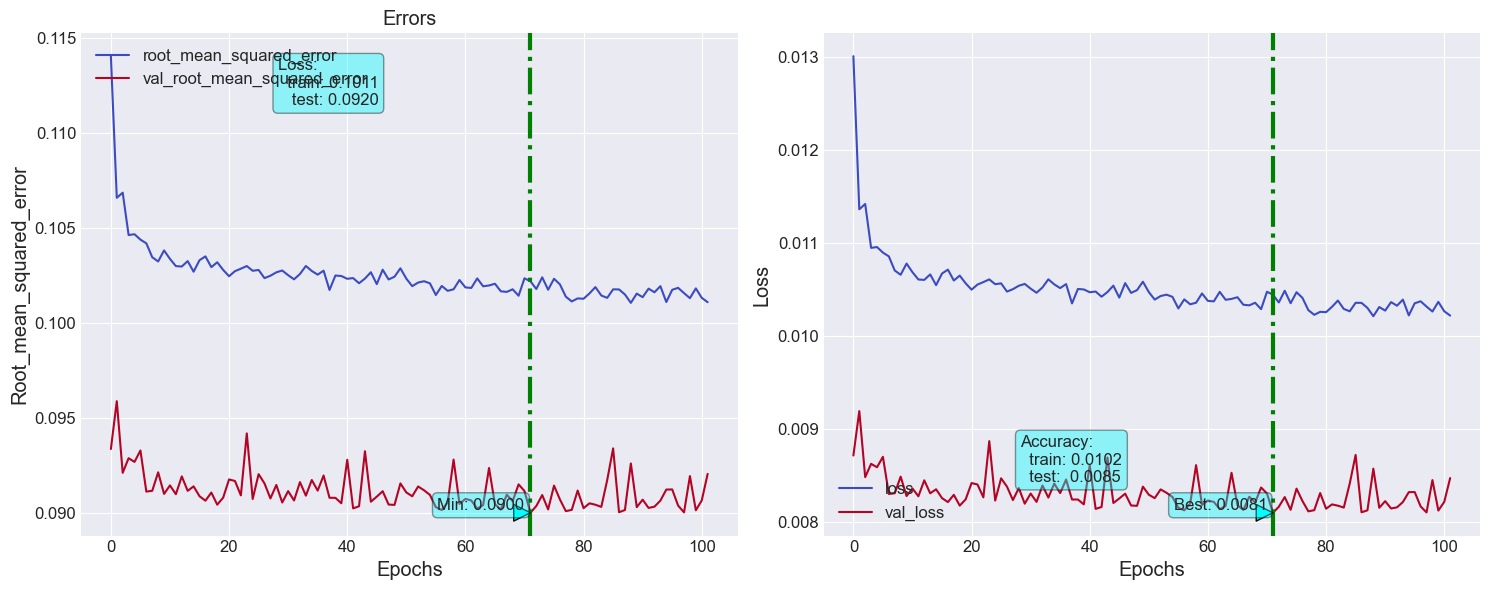

In [24]:
fn_plot_tf_hist(loss_df)
plt.tight_layout()

In [25]:
y_pred= model(X_test)

In [26]:
X_test= X_test.reshape((X_test.shape[0],X_test.shape[2]))
X_test.shape

(25828, 7)

In [27]:
inv_x = np.concatenate((y_pred, X_test), axis = 1)
inv_x = scaler.inverse_transform(inv_x)

y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test), axis = 1)
inv_y = scaler.inverse_transform(inv_y)
inv_y.shape

(25828, 8)

In [28]:
inv_y_pred  =  inv_x[:, 0]
inv_y_pred

array([2.09624513, 2.15968236, 2.52682629, ..., 1.72486314, 1.83268961,
       1.41270383])

In [29]:
inv_y = inv_y[:,0]
inv_y

array([2.62663333, 2.8342    , 3.76716667, ..., 1.65933333, 1.1637    ,
       0.93466667])

In [30]:
r2_score(inv_y, inv_y_pred)

0.5373347495139817